<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Examining-the-data" data-toc-modified-id="Examining-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Examining the data</a></span><ul class="toc-item"><li><span><a href="#Checking-the-correctness-of-the-enrichment-efficiency-calculation" data-toc-modified-id="Checking-the-correctness-of-the-enrichment-efficiency-calculation-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Checking the correctness of the enrichment efficiency calculation</a></span></li></ul></li><li><span><a href="#Analysis-of-features-not-available-in-the-test-sample" data-toc-modified-id="Analysis-of-features-not-available-in-the-test-sample-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Analysis of features not available in the test sample</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data preprocessing</a></span></li></ul></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Change-in-concentration-of-metals-(Au,-Ag,-Pb)-at-different-cleaning-stages" data-toc-modified-id="Change-in-concentration-of-metals-(Au,-Ag,-Pb)-at-different-cleaning-stages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Change in concentration of metals (Au, Ag, Pb) at different cleaning stages</a></span></li><li><span><a href="#Comparison-of-raw-material-granule-size-distribution-in-the-training-and-test-datasets" data-toc-modified-id="Comparison-of-raw-material-granule-size-distribution-in-the-training-and-test-datasets-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Comparison of raw material granule size distribution in the training and test datasets</a></span></li><li><span><a href="#Investigation-of-the-total-concentration-of-all-elements-at-different-stages" data-toc-modified-id="Investigation-of-the-total-concentration-of-all-elements-at-different-stages-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Investigation of the total concentration of all elements at different stages</a></span></li></ul></li><li><span><a href="#Model-building" data-toc-modified-id="Model-building-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model building</a></span><ul class="toc-item"><li><span><a href="#Function-to-calculate-sMAPE" data-toc-modified-id="Function-to-calculate-sMAPE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Function to calculate sMAPE</a></span></li><li><span><a href="#Model-training-and-quality-assessment" data-toc-modified-id="Model-training-and-quality-assessment-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model training and quality assessment</a></span></li></ul></li></ul></div>

# Project description:

A prototype machine learning model needs to be prepared for the company which develops solutions for the efficient operation of industrial plants.

The model needs to predict the recovery rate of gold from gold-bearing ore. We have data with mining and refining parameters at our disposal.

The model will help optimise production so that we don't run a plant with unprofitable characteristics.
We need to:
1. Prepare the data;
2. Conduct an exploratory analysis of the data;
3. Build and train the model.

**Data description**.

**Technological process**
- Rougher feed - feedstock
- Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
    - Xanthate is a xanthogenate (promoter or activator of flotation);
    - Sulphate is sulphate (sodium sulphide in this process);
    - Depressant (sodium silicate).
- Rougher process - flotation
- Rougher tails
- Float banks - flotation system
- Cleaner process
- Rougher Au - refined gold concentrate
- Final Au - final gold concentrate

*Stage parameters*
- Air amount - air volume
- fluid levels
- feed size - size of raw material pellets
- feed rate - feed rate

**Feature names**

The name of the features should be as follows:

`[stage].[type_parameter].[name_parameter]`. Example: `rougher.input.feed_ag`.

Possible values for the `[stage]` block:
- rougher - flotation
- primary_cleaner - primary cleaner
- secondary_cleaner - secondary treatment
- final - final characteristics

Possible values for block `[type_parameter]`:
- input - raw material parameters
- output - product parameters
- state - parameters describing current stage state
- calculation - calculation characteristics

In [1]:
# importing required libraries

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

from matplotlib import dates
import datetime

## Data preparation

### Examining the data

The data are in three files:

- `gold_recovery_train_new.csv` - training sample;
- `gold_recovery_test_new.csv` - test sample;
- `gold_recovery_full_new.csv` - raw data.

Data is indexed by date and time of receipt of information (feature `date`)

Let's read data of source files into variables `df_train`, `df_test`, `df_full` and set column `date` as an index.

In [2]:
try:
    df_train = pd.read_csv('gold_recovery_train_new.csv', index_col='date', parse_dates=['date'])
    df_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date', parse_dates=['date'])
    df_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date', parse_dates=['date'])
    
except FileNotFoundError:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date', parse_dates=['date'])
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date', parse_dates=['date'])
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date', parse_dates=['date'])

Since the original dataset is as a maximally extended dataset in terms of the number of observations and columns, will check its size.

In [3]:
df_full.shape

(19439, 86)

Extending the number of columns displayed, because by default Pandas only displays 20 columns, while our dataset has 86.

In [4]:
pd.set_option('display.max_columns', 100)

For each of the datasets, let us analyse the sample output of the rows as well as the overall data information.

**>> training dataset**

In [5]:
df_train.sample(5)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-24 14:59:59,3.201864,11.256062,8.874001,47.222238,49.115669,6.396199,3.352285,13.830313,3.511858,151.496325,5.492496,6.70,1.087750,6.955909,12.510966,8.449651,34.736459,14.009198,2.950035,8.340226,3.786360,1353.648343,-499.785574,1344.172650,-498.969611,1348.306104,-499.096919,1349.921670,-366.673115,47841.171587,4016.940542,4016.894776,1.885579,6.813484,3.415080,599.953098,56.425045,43.465667,6.439404,15.998706,5.492332,15.999723,5.831149,11.348774,10.005658,30.558548,18.812234,80.143920,4.470854,0.711415,20.015304,1.761980,995.907388,-300.463471,1297.935637,-500.519803,1296.401738,-500.358024,1195.588691,-501.247717,950.603279,-500.325762,949.985734,-501.537679,16.627834,7.852582,3.863150,3.710315,28.465240,-500.847935,23.054652,-500.228329,27.019600,-600.348785,18.995902,-500.355478,14.522420,-502.400608,10.939258,-401.562357,13.989922,-501.256176,11.012383,-500.082454,15.004584,-500.351318
2018-03-17 02:59:59,4.929062,11.162816,7.956675,44.666646,71.333998,10.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

**Calculating the number and share of missing values**

In [7]:
df_train.isna().agg(['sum', 'mean']).T.sort_values('mean', ascending=False).head(30)

,sum,mean
secondary_cleaner.output.tail_sol,1605.0,0.113436
rougher.state.floatbank10_e_air,436.0,0.030815
rougher.input.floatbank11_xanthate,428.0,0.030249
primary_cleaner.output.concentrate_sol,286.0,0.020213
secondary_cleaner.state.floatbank2_a_air,217.0,0.015337
final.output.concentrate_sol,211.0,0.014913
rougher.input.feed_size,144.0,0.010177
rougher.input.feed_pb,100.0,0.007068
final.output.tail_pb,100.0,0.007068
primary_cleaner.input.xanthate,100.0,0.007068


In [8]:
# checking explicit duplicates

df_train.duplicated().sum()

0

**Conclusion:**

The training dataset has 14,149 observations and 86 columns. The dataset shows multiple missing values in most of the columns.

The column with the most missing data is `secondary_cleaner.output.tail_sol` with 1605 missing values (11.34%).

In all other columns the number of missing data is significantly lower. There are no problems with data types. There are no explicit duplicates.

**>> testing dataset**

In [9]:
df_test.sample(5)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-05 18:59:59,221.444067,11.012203,7.440000,1.990334,1595.383211,-499.407205,1598.994224,-492.270827,1493.526480,-503.009419,1601.005493,-500.151548,9.559851,5.047812,648.951157,81.799813,42.905247,10.258999,20.190215,7.004499,20.195618,7.003915,1400.489865,-300.020974,1298.998756,-499.595128,1249.391088,-499.800883,1151.835394,-499.057891,1049.890691,-500.140431,1050.899819,-499.824488,29.089175,-500.147797,25.908151,-500.119239,24.025364,-500.531703,22.019884,-499.934979,19.982626,-501.438896,18.085450,-499.705051,13.994516,-501.309299,9.992212,-500.327633,14.032461,-500.633532
2016-09-08 05:59:59,137.038315,6.983146,7.940000,0.499741,1297.449261,-499.099763,1299.475999,-500.599973,1299.579410,-500.591474,1300.368233,-500.171451,10.722045,3.494074,402.456940,43.591271,32.671660,9.812776,11.996737,5.603082,12.006229,5.598278,1000.545240,-500.022857,1251.547064,-499.569081,1251.205710,-499.858264,1198.009234,-499.411685,1002.068630,-499.098516,951.003192,-501.781938,22.079747,-499.938042,12.035411,-499.690594,11.957180,-500.116535,7.999568,-599.811840,7.954648,-500.201200,4.911544,-601.007608,7.951188,-600.015435,2.894050,-598.137445,19.996226,-599.883856
2016-10-20 21:59:59,162.623387,8.019655,7.350000,1.037566,1612.020646,-499.626302,1699.450054,-500.090657,1698.769602,-499.202465,1700.147266,-500.186760,10.077587,3.709847,372.168018,41.671350,33.400616,10.966905,13.987939,6.598105,13.989076,6.603187,1002.855006,-299.872967,1401.918332,-399.967088,1402.436374,-399.504900,1302.488885,-399.636433,1202.054078,-299.583172,1202.195112,-300.633055,31.982370,-499.160211,27.021935,-500.244663,32.956530,-499.863712,31.013437,-499.736046,20.008453,-497.503194,16.938077,-500.227638,16.947644,-499.871258,13.998753,-499.933472,25.003597,-498.964638
2017-11-16 06:59:59,149.997087,7.998227,6.870000,2.818531,1599.963574,-499.751998,1601.555927,-500.588977,1568.895055,-499.985628,1599.631752,-500.331464,8.969575,2.313530,645.205664,73.828888,42.065260,8.153974,12.571208,7.694976,12.580683,7.701156,1201.776115,-299.851833,1305.008163,-500.0601

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

**Calculating the number and share of missing values**

In [11]:
df_test.isna().agg(['sum', 'mean']).T.sort_values('mean', ascending=False).head(15)

,sum,mean
rougher.input.floatbank11_xanthate,25.0,0.004726
rougher.input.feed_sol,21.0,0.003970
secondary_cleaner.state.floatbank3_a_air,9.0,0.001701
rougher.input.floatbank11_sulfate,8.0,0.001512
primary_cleaner.input.depressant,5.0,0.000945
rougher.input.floatbank10_sulfate,5.0,0.000945
primary_cleaner.input.sulfate,4.0,0.000756
primary_cleaner.input.xanthate,4.0,0.000756
rougher.input.feed_rate,3.0,0.000567
secondary_cleaner.state.floatbank2_a_air,3.0,0.000567


In [12]:
# checking explicit duplicates

df_test.duplicated().sum()

0

**Conclusion:**

The test dataset has 5,290 observations and 52 columns (34 fewer columns than the training dataset). There are almost no missing data in the dataset.

Columns `rougher.input.floatbank11_xanthate` and `rougher.input.feed_sol` = 25(0.5%) and 21(0.4%), respectively, have the most missing values.

In all other columns the number of missing data is either equal or tends to zero. There are no problems with the data types. There are no explicit duplicates.

**>> original dataset**

In [13]:
df_full.sample(5)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-20 03:59:59,3.672569,11.618067,6.884938,46.082938,67.452759,8.551506,2.827701,9.246597,1.955801,131.195497,6.081141,7.30,0.992303,7.482481,14.603608,9.677688,34.272391,18.859979,5.018846,6.664354,3.003973,1600.383278,-501.035186,1601.110039,-499.935425,1599.483838,-501.034128,1599.213400,-500.471448,44076.816631,2817.283448,2817.349903,1.614705,6.009445,3.420627,581.846287,84.231008,45.635689,5.523301,9.332660,6.103848,9.331495,6.606332,12.126031,11.181312,30.140514,17.355232,84.493278,4.149953,0.505660,18.202110,1.171499,1207.776494,-300.071792,1203.786987,-500.269885,1203.129026,-500.116468,1106.504719,-500.672128,999.173944,-500.935379,1002.768352,-497.871209,15.712711,12.491109,0.872353,3.117738,34.951409,-500.243475,28.053625,-499.922803,33.019893,-500.433743,25.004631,-499.916365,27.012997,-500.038423,19.997906,-500.643673,18.011995,-499.799320,14.000686,-499.983734,14.012857,-500.128384
2016-07-14 13:59:59,5.199370,7.942990,11.853051,44.738193,59.668797,7.8

In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

**Calculating the number and share of missing values**

In [15]:
df_full.isna().agg(['sum', 'mean']).T.sort_values('mean', ascending=False).head(30)

,sum,mean
secondary_cleaner.output.tail_sol,1748.0,0.089922
rougher.input.floatbank11_xanthate,453.0,0.023304
rougher.state.floatbank10_e_air,436.0,0.022429
primary_cleaner.output.concentrate_sol,370.0,0.019034
secondary_cleaner.state.floatbank2_a_air,220.0,0.011317
final.output.concentrate_sol,211.0,0.010854
rougher.input.feed_size,145.0,0.007459
primary_cleaner.output.concentrate_pb,116.0,0.005967
primary_cleaner.input.xanthate,104.0,0.005350
final.output.tail_pb,101.0,0.005196


Calculate the total number of missing values and their share in the dataset.

In [16]:
print('Общее кол-во пропусков в исходном датасете:', df_full.isna().sum().sum())
print('Размер исходного датасета:', df_full.size)
print('Доля пропусков в исходном датасете:', round((df_full.isna().sum().sum())/df_full.size, 3))

Общее кол-во пропусков в исходном датасете: 4481
Размер исходного датасета: 1671754
Доля пропусков в исходном датасете: 0.003


In [17]:
# checking explicit duplicates

df_full.duplicated().sum()

0

Calculating the ratio in which the original dataset was split into the training dataset and the test dataset.

In [18]:
print('Доля обучающей выборки от исходного датасета:', round(len(df_train)/len(df_full), 2))
print('Доля тестовой выборки от исходного датасета:', round(len(df_test)/len(df_full), 2))

Доля обучающей выборки от исходного датасета: 0.73
Доля тестовой выборки от исходного датасета: 0.27


**Conclusion:**

The original dataset has 19,439 observations and 86 columns. The dataset shows multiple missing values in most of the columns.

As in the training sample, the column with "tailings" data from secondary product cleaning has the highest number of missing values: `secondary_cleaner.output.tail_sol` - 1,748 missing values (9%).

In all other columns, the number of missing values is significantly lower. The total number of missing values in the dataset is 4481, which is 0.3% of the total dataset values.

There are no problems with the data types. There are no explicit duplicates.

Given the number of observations in the training sample (14,149) and the test sample (5,290) **the original dataset was divided into training and test samples in the ratio 73:27 or nearly 3:1.**

#### Checking the correctness of the enrichment efficiency calculation 

To check the correctness of the enrichment efficiency calculation, let us calculate it on the training sample for the feature `rougher.output.recovery'. Let us find the MAE between our calculations and the value of the feature. The enrichment efficiency is calculated as follows:

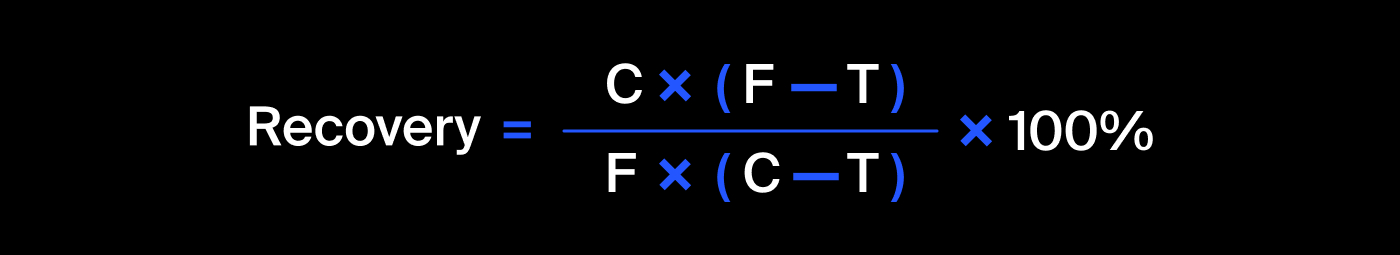

Given that there are missing values in our training sample, in order to calculate enrichment efficiency, we'll form a sample without missing values.

In [19]:
df_recovery_calc = df_train.dropna()

In [20]:
# checking missing values

df_recovery_calc.isna().sum().sum()

0

Defining a function to calculate the Enrichment Efficiency.

In [21]:
'''
To calculate enrichment efficiency, we need three variables:

C - the fraction of gold in the concentrate after flotation (rough concentrate), i.e. in the product (output.concentrate_au);
F - fraction of gold in raw material/concentrate before flotation, i.e. raw material (input.feed_au);
T - fraction of gold in tailings after flotation (rough concentrate), i.e. in the product (output.tail_au).
'''

def recovery_calc(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    
    return (c * (f-t)) / (f * (c-t)) * 100

Applying the function to the training dataset without missing values. Saving the result in the `recovery_check` column.

In [22]:
df_recovery_calc['recovery_check'] = df_recovery_calc.apply(recovery_calc, axis=1)

Visually comparing the calculated and initial values of enrichment efficiency. 

In [23]:
df_recovery_calc[['rougher.output.recovery', 'recovery_check']]

,rougher.output.recovery,recovery_check
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794
...,...,...
2018-08-18 06:59:59,89.574376,89.574376
2018-08-18 07:59:59,87.724007,87.724007
2018-08-18 08:59:59,88.890579,88.890579


A quick glance shows that the original and calculated enrichment efficiency values coincide, i.e. they are calculated correctly in the original dataset. To mathematically confirm the visual detection, let's calculate the mean absolute error (MAE) between the two columns.  

In [24]:
mean_absolute_error(df_recovery_calc['recovery_check'], df_recovery_calc['rougher.output.recovery'])

9.82970122149377e-15

The result is not equal, but tends towards zero. The calculation of the MAE confirms that the calculation of the Enrichment Efficiency in the training sample is correct.

**Conclusion:**

- A dataset with no missing values has been prepared to verify that the recovery efficiency has been calculated correctly.

- The recovery efficiency was calculated for "rough concentrate" using the formula given in the project description.

- The values between the initial and calculated values are identical. MAE = 9.82970122149377e-15 and tends to zero. Accordingly, it can be concluded that the calculation of the Enrichment Efficiency in the original dataset is correct.

### Analysis of features not available in the test sample

As found in Step 1.1 Data Exploration, there are 52 columns in the test sample, i.e. 34 fewer than in the original sample. Let us output the names of the columns that are not available in the test sample.

In [25]:
# apply list comprehansion to filter the column names in the original dataset, 
# that are missing in the test dataset 

[feature for feature in df_full.columns if feature not in df_test.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**Conclusion:**

The analysis of the features in the test sample revealed that some calculation and output features of the process were missing:
- target features: `final.output.recovery' and `rougher.output.recovery', 
- all features relating to product parameters in all processing steps, such as 
    - `rougher` - flotation
    - `primary_cleaner` - primary cleaning
    - `secondary_cleaner` - secondary cleaning
    - `final` - final characteristics 
- calculation characteristics for the flotation stage with parameter type `rougher.calculation`.

The absence of these attributes in the test sample is due to the fact that these parameters cannot be obtained/measured during the process.

### Data preprocessing

As established in Step 1.1. Data Examination, the original dataset has missing values in most of the columns. However, the total number of missing values in the dataset is 4481, which is only 0.3% of the total number of values.

It is not possible to contact the data provider, and given the small proportion of missing values in the total dataset, it is reasonable and rational to delete the rows with missing values.

We will perform data preprocessing (missing data removal) in the original dataset, and then, at the stage of ML model building, re-split the original dataset into training and test samples in the ratio 3:1 (the original dataset was split in such a ratio). We will keep in mind that they should contain only the features that are present in the test sample.

In [26]:
# shape of the original dataset

df_full.shape

(19439, 86)

In [27]:
# removing the objects with missing values

df_full.dropna(inplace=True)

In [28]:
# shape of the original dataset after removing the missing values

df_full.shape

(16094, 86)

**Overall conclusion of Stage 1. "Data preparation":**.

1. Three datasets are presented for the study:

    - an original dataset with 19439 observations,
    - training dataset with 14149 observations,
    - test dataset with 5290 observations.


2. There are no significant data type problems in the data, also there are no full duplicates.


3. The column with the most missing data, in both training and original samples, is `secondary_cleaner.output.tail_sol`. In all other columns, the number of missing values is much lower. The total number of missing values in the original dataset is 4481, which is 0.3% of the total number of values in the original dataset.


4. It is not possible to contact the data provider, and given the low proportion of missing data, it was decided to delete the rows with missing values: 3345(17%) out of 19439 rows.


5. The training dataset and the test dataset are obtained by splitting the original dataset at a ratio of 73:27.


6. The test dataset lacks target features, all features related to product parameters at all stages of processing and calculated characteristics for the flotation stage.


7. Enrichment efficiency is calculated for the crude concentrate according to the formula presented in the project description. The values between the initial and calculated values are identical. MAE value = 9.82970122149377e-15 and tends to zero. Accordingly, it can be concluded that the calculation of the Enrichment Efficiency in the original dataset is correct.


8. Since the training and test datasets are obtained by splitting the original dataset, it was decided to re-divide the original dataset into the training and test samples at a ratio of 3:1 at the stage of building the ML model.

## Exploratory data analysis

### Change in concentration of metals (Au, Ag, Pb) at different cleaning stages

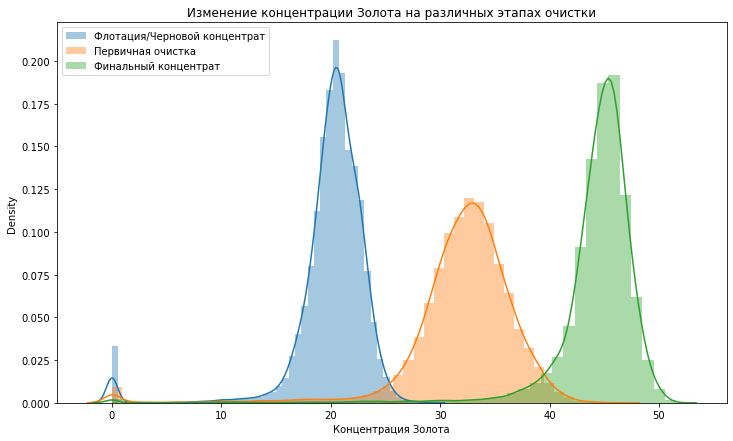

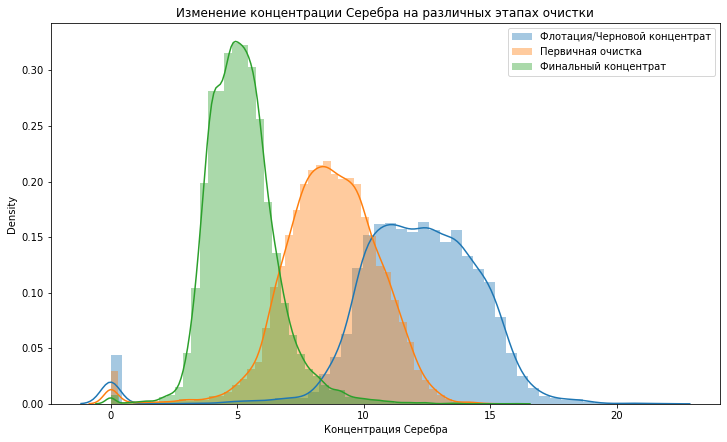

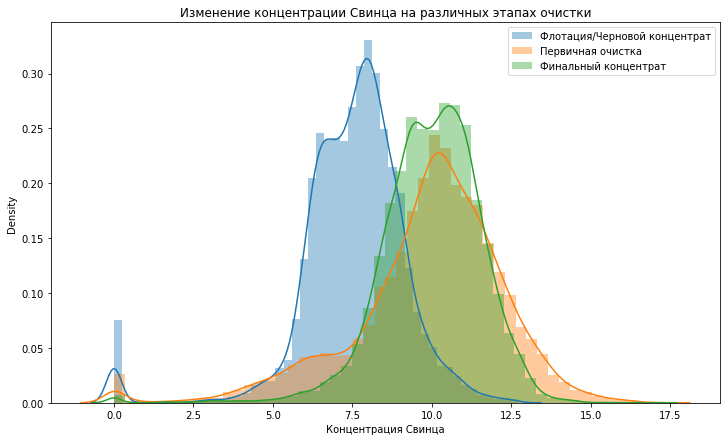

In [29]:
# defining two lists: one with the names of the metals to study and one with the names of the cleaning steps

metals = [('au', 'Золота'), ('ag', 'Серебра'), ('pb', 'Свинца')]
stages = [('rougher.output.concentrate_', 'Флотация/Черновой концентрат'), ('primary_cleaner.output.concentrate_', 'Первичная очистка'), 
               ('final.output.concentrate_', 'Финальный концентрат')]

# let's write a nested loop that goes through the metals by processing phase and plots each iteration

for metal in metals:
    plt.figure(figsize=(12,7))
    for stage in stages:
        ax = sns.distplot(df_full[stage[0] + metal[0]], label=stage[1])
        plt.legend()
        plt.title('Изменение концентрации ' + metal[1] + ' на различных этапах очистки')
        plt.xlabel('Концентрация ' + metal[1])
    plt.show()
        

**Conclusion:** 

The concentration of metals (Au, Ag, Pb) varies differently during the different cleaning stages:

- Gold (Au) shows a positive linear increase from flotation through the primary cleaning to the final concentrate,
- Silver (Ag) shows inverse dynamics - from flotation through primary cleaning to final concentrate the silver concentration decreases,
- Lead (Pb) concentration shows at first a linear increase from flotation stage to the first cleaning stage and then remains at about the same level as after the primary cleaning stage.

### Comparison of raw material granule size distribution in the training and test datasets

To compare the distribution of raw material granule size, let us construct a distribution histogram for the `rougher.input.feed_size' column for both samples, where rougher.input indicates raw material and feed size indicates raw material granule size.

Обучающая выборка - среднее: 60
Тестовая выборка - среднее: 55
Обучающая выборка - медиана: 55
Тестовая выборка - медиана: 55


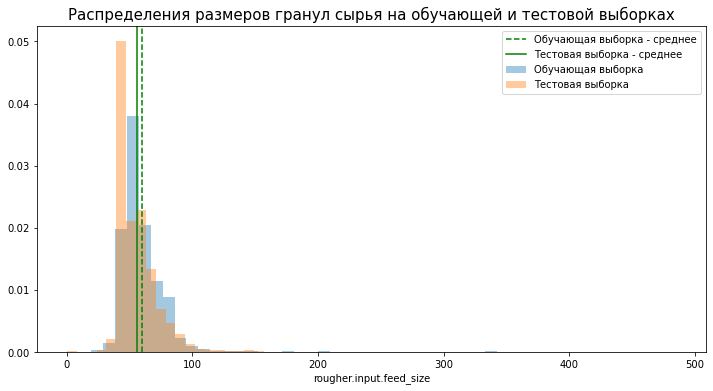

In [30]:
# building a histogram of the raw material granule size distribution on the training and test sets

plt.figure(figsize=(12,6))
plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках', fontsize=15)
sns.distplot(df_train['rougher.input.feed_size'], label='Обучающая выборка', kde=False, norm_hist=True)
sns.distplot(df_test['rougher.input.feed_size'], label='Тестовая выборка', kde=False, norm_hist=True)
plt.axvline(np.mean(df_train['rougher.input.feed_size']), color='g', linestyle='--', label='Обучающая выборка - среднее')
plt.axvline(np.mean(df_test['rougher.input.feed_size']), color='g', linestyle='-', label='Тестовая выборка - среднее')
plt.legend()

print('Обучающая выборка - среднее:', int(df_train['rougher.input.feed_size'].mean()))
print('Тестовая выборка - среднее:', int(df_test['rougher.input.feed_size'].mean()))
print('Обучающая выборка - медиана:', int(df_train['rougher.input.feed_size'].median()))
print('Тестовая выборка - медиана:', int(df_train['rougher.input.feed_size'].median()))

**Conclusion:** the histogram shows that the distributions of the raw material granule sizes in the training and test samples are not significantly different. Calculations of the mean and median also confirm this finding. Since the size of raw material granules is measured in microns, the difference of 5 microns between the average size on the training (60 microns) and the test sample (55 microns) is considered to be insignificant in this case.

### Investigation of the total concentration of all elements at different stages

Selecting the columns to calculate the total concentration by processing stage.

In [31]:
input_sum = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
output_rougher_sum = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
output_final_sum = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']

Generating individual dataframes separately for each processing step, with the columns selected.

In [32]:
df_input_sum = df_full[input_sum]
df_output_rougher_sum = df_full[output_rougher_sum]
df_output_final_sum = df_full[output_final_sum]

Calculating the total concentration of all elements in each processing stage. 

In [33]:
df_input_sum['rougher.input.feed_sum'] = df_input_sum.apply(np.sum, axis=1)
df_output_rougher_sum['rougher.output.concentrate_sum'] = df_output_rougher_sum.apply(np.sum, axis=1)
df_output_final_sum['final.output.concentrate_sum'] = df_output_final_sum.apply(np.sum, axis=1)

df_output_final_sum.head()

,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_sum
date,,,,,
2016-01-15 00:00:00,42.192020,6.055403,9.889648,5.507324,63.644396
2016-01-15 01:00:00,42.701629,6.029369,9.968944,5.257781,63.957723
2016-01-15 02:00:00,42.657501,6.055926,10.213995,5.383759,64.311180
2016-01-15 03:00:00,42.689819,6.047977,9.977019,4.858634,63.573449
2016-01-15 04:00:00,42.774141,6.148599,10.142511,4.939416,64.004667


Visualising the total concentration of all elements in the different processing steps.

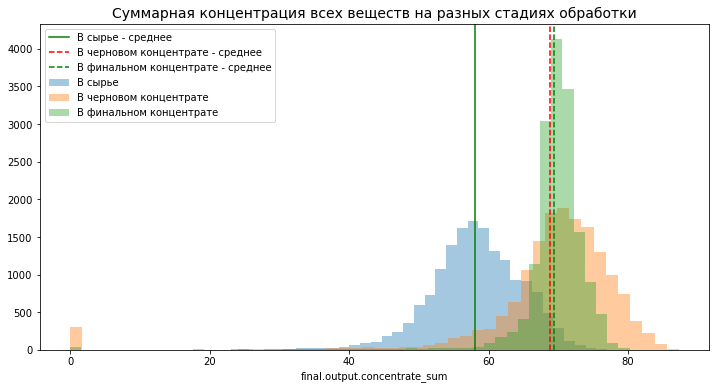

In [34]:
plt.figure(figsize=(12,6))
plt.title('Cуммарная концентрация всех веществ на разных стадиях обработки', fontsize=14)
sns.distplot(df_input_sum['rougher.input.feed_sum'], label='В сырье', kde=False)
sns.distplot(df_output_rougher_sum['rougher.output.concentrate_sum'], label='В черновом концентрате', kde=False)
sns.distplot(df_output_final_sum['final.output.concentrate_sum'], label='В финальном концентрате', kde=False)

plt.axvline(np.mean(df_input_sum['rougher.input.feed_sum']),color='g', linestyle='-', label='В сырье - среднее')
plt.axvline(np.mean(df_output_rougher_sum['rougher.output.concentrate_sum']),color='r', linestyle='--', label='В черновом концентрате - среднее')
plt.axvline(np.mean(df_output_final_sum['final.output.concentrate_sum']),color='g', linestyle='--', label='В финальном концентрате - среднее')

plt.legend()

The graph shows the distribution of the total concentration values with a skew to the right for all three processing stages. There is a distinct left-hand tail for each of the stages. In addition, a column at zero is detected, indicating the presence of anomalies, as the total concentration of all substances at some stage cannot be equal to zero.

Clearly, there are outliers in the dataset. Let's build a boxplot.

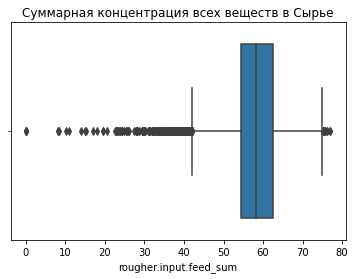

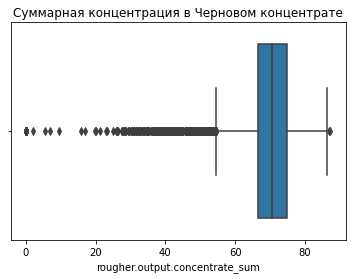

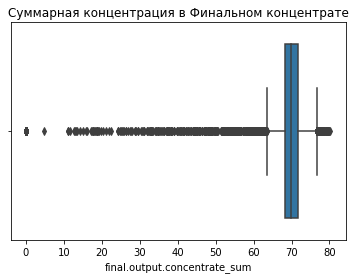

In [35]:
sns.boxplot(df_input_sum['rougher.input.feed_sum'])
plt.title('Cуммарная концентрация всех веществ в Сырье')
plt.show()

sns.boxplot(df_output_rougher_sum['rougher.output.concentrate_sum'])
plt.title('Cуммарная концентрация в Черновом концентрате')
plt.show()

sns.boxplot(df_output_final_sum['final.output.concentrate_sum'])
plt.title('Cуммарная концентрация в Финальном концентрате')
plt.show()

In all three plots, we observe a bold black trace to the left of the left whisker of the boxplot, indicating multiple outliers and confirming the presence of a left-hand tail on the histogram plotted earlier. 

To detect possible anomalies and inadequate values in the data, let's analyse the overall distribution of values in the datasets using the `describe()` function. 

In [36]:
display(df_input_sum.describe(), df_output_rougher_sum.describe(), df_output_final_sum.describe())

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_sum
count,16094.000000,16094.000000,16094.000000,16094.000000,16094.000000
mean,8.516990,8.985281,3.636621,36.962618,58.101510
std,1.828474,1.910084,1.041859,4.874568,6.761203
min,0.010000,0.010000,0.010000,0.010000,0.040000
25%,7.080266,7.426978,2.928259,34.408814,54.363838
50%,8.366978,8.882196,3.572770,37.272903,58.226620
75%,9.939579,10.398254,4.272312,40.165076,62.578101
max,13.731330,14.596026,7.142594,53.477742,76.978947


,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_sum
count,16094.000000,16094.000000,16094.000000,16094.000000,16094.000000
mean,20.052152,12.084945,7.553095,29.115629,68.805821
std,3.620905,2.697948,1.688073,5.783116,12.095202
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.142941,10.664288,6.696978,27.532851,66.643291
50%,20.507430,12.232367,7.698308,30.100039,70.701213
75%,21.916971,13.835104,8.510786,32.431892,74.763404
max,28.824507,21.725695,12.702148,38.351193,87.273435


,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_sum
count,16094.000000,16094.000000,16094.000000,16094.000000,16094.000000
mean,44.307437,5.190976,9.997593,9.871835,69.367841
std,4.210135,1.333257,1.568785,2.754533,6.038211
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.431184,4.277722,9.103183,8.156531,68.372986
50%,44.986391,5.083578,10.092386,9.618630,69.943177
75%,46.253912,5.894149,11.030644,11.324848,71.669414
max,51.571885,16.001945,17.031899,19.615720,80.210644


In support of our conclusion about the presence of multiple emissions, analysis of the overall distribution of values in the datasets indicates that there are observations with concentrations of all substances at different stages - in the raw material, in the rough and final concentrates - equal to zero or close to zero (0.01). 

In the absence of an opportunity to clarify the information with the customer of the study, it is decided to remove the outliers.

In [37]:
df_full['rougher.input.feed_sum'] = df_input_sum['rougher.input.feed_sum']
df_full['rougher.output.concentrate_sum'] = df_output_rougher_sum['rougher.output.concentrate_sum']
df_full['final.output.concentrate_sum'] = df_output_final_sum['final.output.concentrate_sum']

To determine the limits of the normal distribution (the whiskers in the boxplot), we define a function to determine the left and right boxplot whiskers.

In [38]:
def whiskers_lim(column):
    input_data = df_full[column].describe()
    
    # calculating IQR
    iqr = input_data[6] - input_data[4]
    
    # calculating left and right whiskers    
    whisker_l = round(input_data[4] - 1.5 * iqr, 0)
    whisker_r = round(input_data[6] + 1.5 * iqr, 0)

    # if left whisker less than min value, assigning it a minimal value
    if whisker_l < input_data[3]: whisker_l = input_data[3] 
        
    # if right whisker greater than max value, assigning it a maximal value
    if whisker_r > input_data[7]: whisker_r = input_data[7]
        
    return whisker_l, whisker_r

Let's find the limits of the normal distribution separately for each column summarizing the concentration of substances in each gold processing step. 

In [39]:
print('Границы усов диаграммы размаха на этапе Сырья:', whiskers_lim('rougher.input.feed_sum'))
print('Границы усов диаграммы размаха на этапе Чернового концентрата:', whiskers_lim('rougher.output.concentrate_sum'))
print('Границы усов диаграммы размаха на этапе Финального концентрата:', whiskers_lim('final.output.concentrate_sum'))

Границы усов диаграммы размаха на этапе Сырья: (42.0, 75.0)
Границы усов диаграммы размаха на этапе Чернового концентрата: (54.0, 87.0)
Границы усов диаграммы размаха на этапе Финального концентрата: (63.0, 77.0)


We remove the outliers in the original dataset. Since no particular anomalies or large outliers beyond the right-hand limit are detected, we cut off in the original dataset only the outliers to the left of the left-hand whisker of the boxplot.

In [40]:
df_full = df_full[(df_full['rougher.input.feed_sum'] > 0.01) & 
                  (df_full['rougher.output.concentrate_sum'] > 0) & 
                  (df_full['final.output.concentrate_sum'] > 0)]

In [41]:
df_full.shape

(15753, 89)

Visualizing after removing the outliers. 

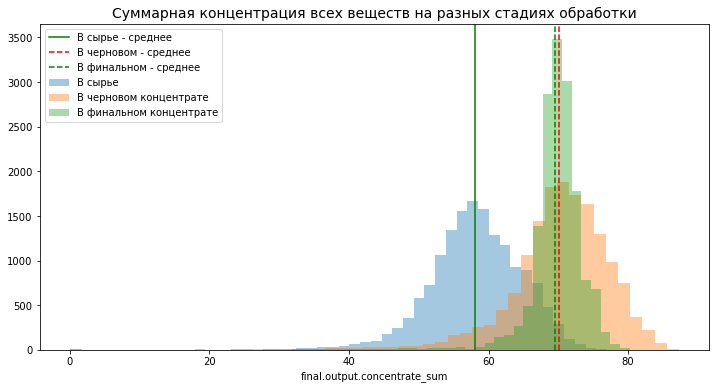

In [42]:
plt.figure(figsize=(12,6))
plt.title('Cуммарная концентрация всех веществ на разных стадиях обработки', fontsize=14)
sns.distplot(df_full['rougher.input.feed_sum'], label='В сырье', kde=False)
sns.distplot(df_full['rougher.output.concentrate_sum'], label='В черновом концентрате', kde=False)
sns.distplot(df_full['final.output.concentrate_sum'], label='В финальном концентрате', kde=False)

plt.axvline(np.mean(df_full['rougher.input.feed_sum']),color='g', linestyle='-', label='В сырье - среднее')
plt.axvline(np.mean(df_full['rougher.output.concentrate_sum']),color='r', linestyle='--', label='В черновом - среднее')
plt.axvline(np.mean(df_full['final.output.concentrate_sum']),color='g', linestyle='--', label='В финальном - среднее')

plt.legend()

## Model building

### Function to calculate sMAPE

The formula for calculating the sMAPE metric is shown in the figure:

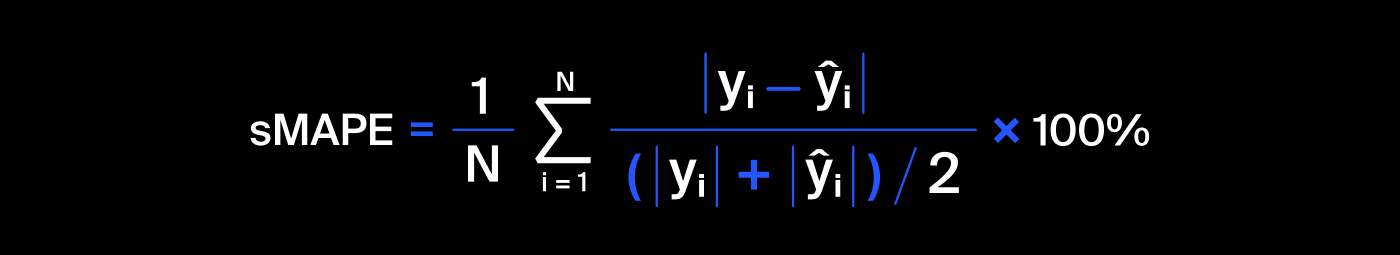

Defining the function to calculate this metric.

In [43]:
# function to calculate sMAPE metric

def smape(y_test, y_predict):
    
    y_test, y_predict = np.array(y_test), np.array(y_predict)
    
    return np.mean(np.abs(y_test - y_predict) / ((np.abs(y_test) + np.abs(y_predict))/2)) * 100

### Model training and quality assessment

Will train different models and assess their quality by cross-validation.

Will create a list to consolidate the best model hyperparameters.

In [44]:
models = []

**-- Initializing the models**

In [45]:
# Linear Regression

lr = LinearRegression(n_jobs=-1)

param_grid={'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}

models.append(('lr', lr, param_grid))

In [46]:
# Decision Tree Regressor

dtr = DecisionTreeRegressor(random_state=12345, max_features='auto')

param_grid = {'max_depth': np.arange(10, 20)}

models.append(('dtr', dtr, param_grid))

In [47]:
# Random Forest Regressor

rfr = RandomForestRegressor(random_state=12345, n_estimators=30, max_features='auto', n_jobs=-1)

param_grid = {'max_depth': np.arange(10, 20)}

models.append(('rfr', rfr, param_grid))

**-- Splitting the original dataset into train and test sets and will define features and target**

We split our pre-processed dataset into training and test samples at a ratio of 3:1. We also define non-target and target features. We remember that the test set does not contain all the columns that are present in the original dataset. Therefore upon splitting, we shall keep in the training and test samples only columns that are present in the initial test sample. They will be the features, since the original test set did not contain the target features (by project condition).

In [48]:
# defining features

features = df_test.columns

In [49]:
# splitting original dataset into train and test datasets at a ration 3:1

df_train, df_test = train_test_split(df_full, random_state=12345, test_size=0.25)

In [50]:
# defining features for each respective dataset

x_train = df_train[features]
x_test = df_test[features]

In [51]:
# defining targets for each respective dataset

y_train_final = df_train['final.output.recovery']
y_train_rougher = df_train['rougher.output.recovery']
y_test_final = df_test['final.output.recovery']
y_test_rougher = df_test['rougher.output.recovery']

In [52]:
# scaling numeric features by StandardScaler()

scaler = StandardScaler()
scaler.fit(x_train[features])

# transforming train and test datasets by using transform()

x_train[features] = scaler.transform(x_train[features])
x_test[features] = scaler.transform(x_test[features])

Will define a function that will enumerate the hyperparameters of the models across the hyperparameter grid and return the best of them. 

In [53]:
# function to enumerate and return the best model hyperparameters

def grid_search(model, param_grid, cv, x, y):
    
    grid_model = GridSearchCV(model, param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)
    grid_model.fit(x, y)
    best_estimator = grid_model.best_estimator_
    
    return best_estimator

Let's declare a function that will collect into a report the best sMAPE metrics for each of the models in the training sample.

In [54]:
def report_builder(models):
    
    report = []
    
    for model in models:
        # one by one for each model from our list of models:
        
        # 1. fit the model with enumerating hyperparameters across the grid with 5 fold cross-validation, 
        # separetly for final and rough concentrate as a targets
        
        grid_final = grid_search(model[1], model[2], 5, x_train, y_train_final)
        grid_rougher = grid_search(model[1], model[2], 5, x_train, y_train_rougher)
        
        # 2. calculating model predictions separately for final and rough concentrate on the train set 

        predictions_final = list(grid_final.predict(x_train))
        predictions_rougher = list(grid_rougher.predict(x_train))
        
        # 3. calculating sMAPE metric separately for each target feature: for final and rough concentrate

        smape_final = smape(y_train_final, predictions_final)
        smape_rougher = smape(y_train_rougher, predictions_rougher)
        
        # 4. calculating total sMAPE based on formula, defined in project conditions

        total_smape = 0.25*smape_rougher + 0.75*smape_final
        
        # 5. appending the reports list with model, metrics calculated and best model hyperparameters
        # 6. transform the list into dataframe to better visual representation 

        report.append((model[0], smape_final, smape_rougher, total_smape, grid_final, grid_rougher))
       
    final_report = pd.DataFrame(report, columns=['Model', 'sMAPE_final', 'sMAPE_rougher', 'Total_sMAPE', 'grid_final_params', 'grid_rougher_params'])
    
    return final_report

In [55]:
final_report = report_builder(models)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [56]:
final_report

,Model,sMAPE_final,sMAPE_rougher,Total_sMAPE,grid_final_params,grid_rougher_params
0,lr,6.932031,3.952628,6.187180,"LinearRegression(n_jobs=-1, normalize=False)","LinearRegression(n_jobs=-1, normalize=False)"
1,dtr,4.787494,1.880620,4.060775,"DecisionTreeRegressor(max_depth=10, max_featur...","DecisionTreeRegressor(max_depth=12, max_featur..."
2,rfr,2.676559,1.093577,2.280814,"(DecisionTreeRegressor(max_depth=19, max_featu...","(DecisionTreeRegressor(max_depth=18, max_featu..."


In [57]:
final_report[['Model', 'Total_sMAPE']].sort_values(by='Total_sMAPE')

,Model,Total_sMAPE
2,rfr,2.280814
1,dtr,4.060775
0,lr,6.187180


The best (lowest) value of the sMAPE metric is shown by the RandomForestRegressor model. Let's test this model on a test sample.

In [58]:
# initialising the model 

rfr_model_final = RandomForestRegressor(n_estimators=30, max_depth=19, max_features='auto', n_jobs=-1, random_state=12345)
rfr_model_rougher = RandomForestRegressor(n_estimators=30, max_depth=18, max_features='auto', n_jobs=-1, random_state=12345)

# fitting the model separately for each processing stage - final and rough concentrate

rfr_model_final.fit(x_train, y_train_final)
rfr_model_rougher.fit(x_train, y_train_rougher)

# separately calculating the model predictions

predictions_final = rfr_model_final.predict(x_test)
predictions_rougher = rfr_model_rougher.predict(x_test)

# calculating sMAPE metric, separately for each target feature

smape_final = smape(y_test_final, predictions_final)
smape_rougher = smape(y_test_rougher, predictions_rougher)

# alculating total sMAPE based on formula, defined in project conditions

total_smape = 0.25*smape_rougher + 0.75*smape_final

print('Итоговый sMAPE на тестовой выборке:', total_smape)

Итоговый sMAPE на тестовой выборке: 4.307488126278986


**Conclusion:**.

1. Using GridSearchCV we selected the best hyperparameters for Linear Regression, Decision Tree Regressor and Random Forest Regressor models.


2. For each best model, we calculated the sMAPE metric on the training sample. The final sMAPE for each of the models in the training sample was as follows:
    - Random Forest Regressor = 2.28
    - Decision Tree Regressor = 4.06
    - Linear Regression - 6.19.


The best model in terms of Total sMAPE metric on the training set (Random Forest Regressor) was tested on the test set and got the value of Total sMAPE = 4.31. 